In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Import Data
import tensorflow as tf
import numpy as np
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

import time

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

/Users/lin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Data Description

In [3]:
# train dataset
print('Train dataset without label:', mnist.train.images.shape) 
print('Train dataset label in one-hot vectors form:', mnist.train.labels.shape) 

# test dataset
print('Test dataset without label:', mnist.test.images.shape) 
print('Test dataset label in one-hot vectors form:', mnist.test.labels.shape) 

# validation dataset
print('Validation dataset without label:', mnist.validation.images.shape) 
print('Validation dataset label in one-hot vectors form:', mnist.validation.labels.shape) 

Train dataset without label: (55000, 784)
Train dataset label in one-hot vectors form: (55000, 10)
Test dataset without label: (10000, 784)
Test dataset label in one-hot vectors form: (10000, 10)
Validation dataset without label: (5000, 784)
Validation dataset label in one-hot vectors form: (5000, 10)


In [4]:
image_size = mnist.train.images.shape[1] # 784
labels_count = mnist.train.labels.shape[1] # 10
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

# Softmax

In [25]:
start_time = time.time()
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x, W) + b) # predicted
y_ = tf.placeholder(tf.float32, [None, 10]) # true value

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])) # loss
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(20000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
  if i % 1000 == 0:
        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
print("--- %s seconds ---" % (time.time() - start_time))

0.4037
0.9189
0.9225
0.922
0.9214
0.9256
0.9214
0.9235
0.9245
0.9252
0.9254
0.9234
0.9207
0.9222
0.9236
0.9222
0.925
0.9267
0.9241
0.9243
--- 33.25000333786011 seconds ---


# CNN

---
Neural Network Process: <br/>
image -> convolution -> max pooling -> convolution -> max pooling -> fully connected -> fully connected -> classifier

In [7]:
def compute_accuracy(v_xs, v_ys):
    global prediction
    y_pre = sess.run(prediction, feed_dict={xs: v_xs, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

def weight_variable(shape):
    inital = tf.truncated_normal(shape, stddev=0.1) # create normal distribution
    return tf.Variable(inital)

def bias_variable(shape):
    inital = tf.constant(0.1, shape=shape)
    return tf.Variable(inital)

def conv2d(x, W):
    # x: all inputs; W: weight
    # strides[1,x_movement,y_movement,1]: the output is the same size as the input
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# pooling : extract the maximum value
# [[0,3],[4,2]] => 4

def max_pool_2x2(x):
    # strides=[1,2,2,1] -> make 2(1+1_xmovement)*2(1+1_ymovement) into 1*1 -> squize the image 
    # ksize: extract info from 2*2 
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [9]:
start_time = time.time()

# Define placeholder for inputs to network

## conv1 layer ##
xs = tf.placeholder(tf.float32, [None, 784]) # 28x28
W_conv1 = weight_variable([5, 5, 1, 32]) #patch 5x5, in channel size 1, out size 32
b_conv1 = bias_variable([32])
x_image = tf.reshape(xs, [-1, image_width, image_height, 1]) # -1: n_sample 1: our display image is in black/white 
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # outpt size of h_convl will be 28*28*32
h_pool1 = max_pool_2x2(h_conv1) # output size of h_pool will be 14*14*32

## conv2 layer ##
W_conv2 = weight_variable([5, 5, 32, 64]) #patch 5x5, in channel size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # outpt size of h_convl will be 14*14*64
h_pool2 = max_pool_2x2(h_conv2) # output size of h_pool will be 7*7*64

## fc1 layer ##
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64]) #[n_samples, 7,7,64]  => [n_samples, 7*7*64]
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## output layer ##
W_fc2 = weight_variable([1024, labels_count]) #labels_count: contains 0-9
b_fc2 = bias_variable([10])
prediction = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
ys = tf.placeholder(tf.float32, [None, 10])

# Evaluation
cross_entropy = tf.reduce_mean(-tf.reduce_sum(ys * tf.log(prediction), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

sess = tf.Session()
sess.run(tf.initialize_all_variables())
for i in range(20000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={xs: batch_xs, ys: batch_ys, keep_prob:0.5})
    if i % 1000 == 0:
        print(compute_accuracy(
            mnist.test.images, mnist.test.labels))

print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0.1003
0.9682
0.9802
0.9838
0.9864
0.9873
0.9885
0.99
0.9903
0.9905
0.991
0.9917
0.9914
0.9913
0.9924
0.9921
0.9923
0.992
0.9919
0.9929
--- 9000.995035886765 seconds ---


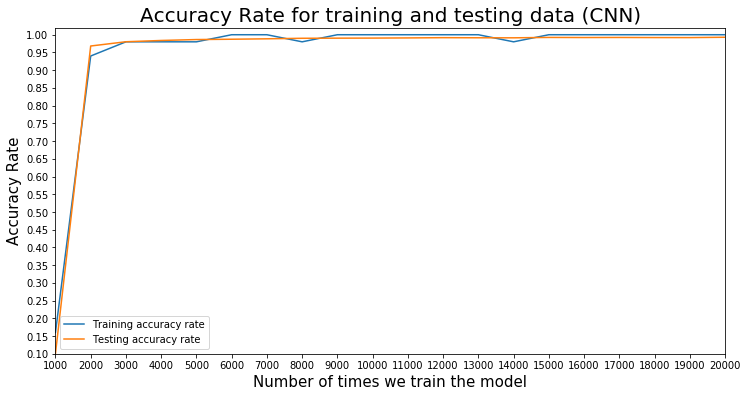

In [96]:
x = np.arange(1000, 21000, 1000)
y = np.array([
0.160,
0.940,
0.980,
0.980,
0.980,
1.000,
1.000,
0.980,
1.000,
1.000,
1.000,
1.000,
1.000,
0.980,
1.000,
1.000,
1.000,
1.000,
1.000,
1.000
])
fig, ax = plt.subplots(figsize=(12,6))
Train, = plt.plot(x, y, '-', label='Training accuracy rate')
plt.xticks(np.arange(1000, 21000, 1000))
plt.xlim(1000,20000)
plt.ylim(0.1,1.02)
plt.yticks(np.arange(0.1,1.05,0.05))
plt.xlabel('Number of times we train the model', fontsize=15)
plt.ylabel('Accuracy Rate', fontsize=15)
plt.title('Accuracy Rate for training and testing data (CNN)', fontsize=20)

x = np.arange(1000, 21000, 1000)
y = np.array([
0.1003,
0.9682,
0.9802,
0.9838,
0.9864,
0.9873,
0.9885,
0.99,
0.9903,
0.9905,
0.991,
0.9917,
0.9914,
0.9913,
0.9924,
0.9921,
0.9923,
0.992,
0.9919,
0.9929])
Test, = plt.plot(x, y, '-', label='Testing accuracy rate')
plt.legend(handles=[Train, Test])
plt.show()
fig.savefig("/Users/lin/Desktop/ST443_Project1/Fig/Accuracy_Rate_CNN.png", format="PNG")

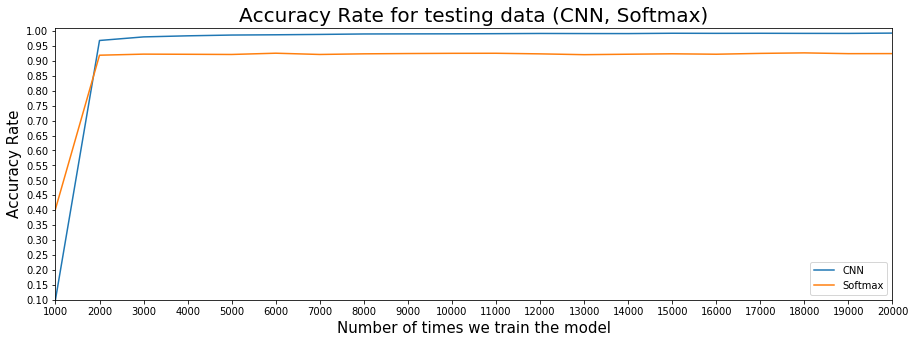

In [76]:
x = np.arange(1000, 21000, 1000)
y = np.array([
0.1003,
0.9682,
0.9802,
0.9838,
0.9864,
0.9873,
0.9885,
0.99,
0.9903,
0.9905,
0.991,
0.9917,
0.9914,
0.9913,
0.9924,
0.9921,
0.9923,
0.992,
0.9919,
0.9929])
fig, ax = plt.subplots(figsize=(15,5))
CNN, = plt.plot(x, y, '-', label='CNN')
plt.xticks(np.arange(1000, 21000, 1000))
plt.xlim(1000,20000)
plt.ylim(0.1,1.01)
plt.yticks(np.arange(0.1,1.05,0.05))

plt.xlabel('Number of times we train the model', fontsize=15)
plt.ylabel('Accuracy Rate', fontsize=15)
plt.title('Accuracy Rate for testing data (CNN, Softmax)', fontsize=20)


x = np.arange(1000, 21000, 1000)
y = np.array([
0.4037,
0.9189,
0.9225,
0.922,
0.9214,
0.9256,
0.9214,
0.9235,
0.9245,
0.9252,
0.9254,
0.9234,
0.9207,
0.9222,
0.9236,
0.9222,
0.925,
0.9267,
0.9241,
0.9243])
Softmax, = plt.plot(x, y, '-', label='Softmax')
plt.legend(handles=[CNN, Softmax])
plt.show()
fig.savefig('/Users/lin/Desktop/ST443_Project1/Fig/Accuracy_Rate_CNN_Softmax.png', format="PNG") 

# RandomForest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()

y=[]
for i in range(10, 210, 10):
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators= i, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
    clf_rf.fit(mnist.train.images,  mnist.train.labels)
    y_pred_rf = clf_rf.predict(mnist.test.images)
    acc_rf = accuracy_score(mnist.test.labels, y_pred_rf)
    print(acc_rf)
    y.append(acc_rf)
    
print("--- %s seconds ---" % (time.time() - start_time))

0.8611
0.8839
0.8909
0.893
0.8953
0.8968
0.8988
0.9017
0.8981
0.9033
0.9019
0.9019
0.9006
0.9011
0.9
0.9052
0.9031
0.9038
0.9029
0.9039
--- 2121.6068861484528 seconds ---


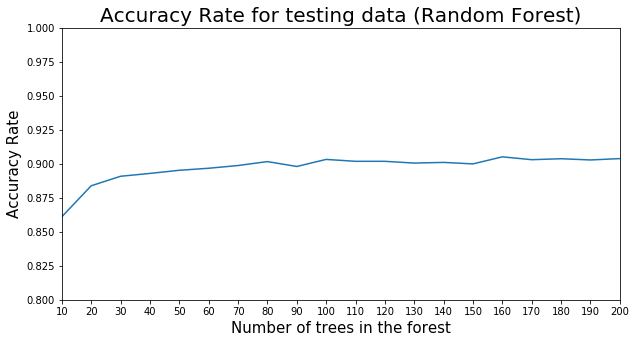

In [98]:
x = range(10, 210, 10)
plt.subplots(figsize=(10,5))
y = np.array([
0.8611,0.8839,0.8909,0.893,
0.8953,0.8968,0.8988,0.9017,
0.8981,0.9033,0.9019,0.9019,
0.9006,0.9011,0.9,0.9052,
0.9031,0.9038,0.9029,0.9039])

RandomForest, = plt.plot(x, y, '-', label='RandomForest')
plt.xlabel('Number of trees in the forest', fontsize=15)
plt.xticks(range(10, 210, 10))
plt.xlim(10,200)
plt.ylim(0.80,1)
plt.ylabel('Accuracy Rate', fontsize=15)
plt.title('Accuracy Rate for testing data (Random Forest)', fontsize=20)
plt.show()
fig.savefig('/Users/lin/Desktop/ST443_Project1/Fig/Accuracy_Rate_Random_Forest_B.png', format="PNG") 

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

start_time = time.time()

# wrong -> this is not bagging because need to change max_features to None
y=[]
for i in range(10, 610, 100):
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators= i, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
    clf_rf.fit(mnist.train.images,  mnist.train.labels)
    y_pred_rf = clf_rf.predict(mnist.test.images)
    acc_rf = accuracy_score(mnist.test.labels, y_pred_rf)
    print(acc_rf)
    y.append(acc_rf)
    
print("--- %s seconds ---" % (time.time() - start_time))

0.8631
0.9011
0.9029
0.9032
0.9044
0.9047
--- 1404.354747056961 seconds ---


In [10]:
start_time = time.time()

# wrong -> this is not bagging because need to change max_features to None
y_oob=[]
for i in range(10, 610, 100):
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators= i, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
    clf_rf.fit(mnist.train.images,  mnist.train.labels)
    y_pred_rf = clf_rf.predict(mnist.test.images)
    acc_rf = accuracy_score(mnist.test.labels, y_pred_rf)
    print(acc_rf)
    y_oob.append(acc_rf)
    
print("--- %s seconds ---" % (time.time() - start_time))

/Users/lin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/lin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.8656
0.8989
0.9039
0.9046
0.9034
0.904
--- 1540.6389093399048 seconds ---


In [11]:
start_time = time.time()

y_sqrt=[]
for i in range(10, 610, 100):
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators= i, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
    clf_rf.fit(mnist.train.images,  mnist.train.labels)
    y_pred_rf = clf_rf.predict(mnist.test.images)
    acc_rf = accuracy_score(mnist.test.labels, y_pred_rf)
    print(acc_rf)
    y_sqrt.append(acc_rf)
    
print("--- %s seconds ---" % (time.time() - start_time))

0.8681
0.9018
0.9033
0.9033
0.903
0.9054
--- 1424.8207631111145 seconds ---


In [12]:
start_time = time.time()

y_sqrt_oob=[]
for i in range(10, 610, 100):
    clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators= i, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)
    clf_rf.fit(mnist.train.images,  mnist.train.labels)
    y_pred_rf = clf_rf.predict(mnist.test.images)
    acc_rf = accuracy_score(mnist.test.labels, y_pred_rf)
    print(acc_rf)
    y_sqrt_oob.append(acc_rf)
    
print("--- %s seconds ---" % (time.time() - start_time))

/Users/lin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/lin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.8607
0.8991
0.9033
0.9032
0.9036
0.9055
--- 1497.6523070335388 seconds ---


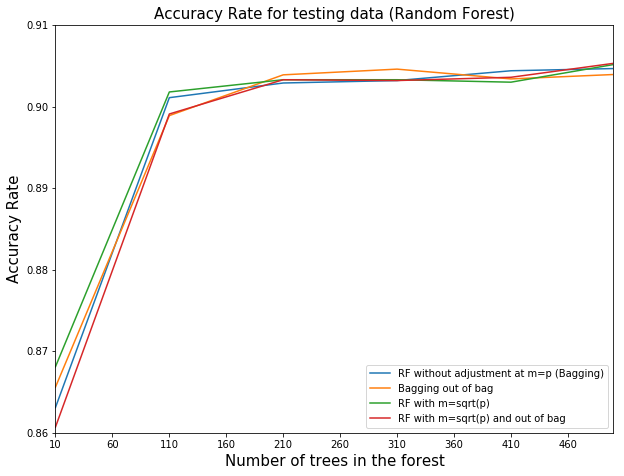

In [105]:
x = np.arange(10, 610, 100)
y = np.array([0.8631,0.9011,0.9029,0.9032,0.9044,0.9047])
fig, ax = plt.subplots(figsize=(10,7.5))
RF_o, = plt.plot(x, y, '-', label='RF without adjustment at m=p (Bagging)')
plt.xticks(np.arange(10, 610, 50))
plt.xlim(10,500)
plt.ylim(0.86,0.91)
plt.yticks(np.arange(0.86,0.91,0.01))

plt.xlabel('Number of trees in the forest', fontsize=15)
plt.ylabel('Accuracy Rate', fontsize=15)
plt.title('Accuracy Rate for testing data (Random Forest)', fontsize=15)

RF_oob, = plt.plot(x, y_oob, '-', label='Bagging out of bag')
RF_sqrt, = plt.plot(x, y_sqrt, '-', label='RF with m=sqrt(p)')
RF_sqrt_oob, = plt.plot(x, y_sqrt_oob, '-', label='RF with m=sqrt(p) and out of bag')

plt.legend(handles=[RF_o, RF_oob, RF_sqrt, RF_sqrt_oob])
plt.show()
fig.savefig('/Users/lin/Desktop/ST443_Project1/Fig/Random_Forest_A.png') 

# KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(mnist.train.images,  mnist.train.labels)
y_pred_knn = clf_knn.predict(mnist.test.images)
acc_knn = accuracy_score(mnist.test.labels, y_pred_knn)
print ("nearest neighbors accuracy: ",acc_knn)

nearest neighbors accuracy:  0.9657
